In this notebook we'll explore the solution found by our classifier.

In [1]:
#!pip install seaborn

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

import utils
import rnn

%load_ext autoreload
%matplotlib inline

Using TensorFlow backend.


In [ ]:
%autoreload
import utils

### Re-create the training data using saved model params

In [2]:
# Pick a model to load and extract the hyperparams.

#model_name = 'models/64_64_64_0.5_False_20_20000_0.3_64_0.0_002_0.53010_0.73065_titles.h5'
model_name = 'models/64_64_64_0.5_False_20_34414_0.15_64_0.0_3_titles_002_0.52099_0.74574_titles.h5'

gru_dim, embed_dim, dense_dim, dropout, bidirectional, maxlen, topn, test_size, batch_size = \
  utils.parse_model_name(model_name)
  
# Load the keras model
model = load_model(model_name)

In [3]:
%%time

# Load the source data frame

filepath = '../data/data-True-0.pkl'
df, keep_stops, min_sents, vocab, w2i, i2w = utils.read_dataset(filepath)

CPU times: user 1.56 s, sys: 24 ms, total: 1.58 s
Wall time: 1.57 s


In [4]:
%%time

# Filter out uncommon words using parameters parsed from model name.

df['encoded_text'] = utils.filter_top_words(df['encoded_text'].tolist(), topn)

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 62.3 ms


In [5]:
# Create input/output data

X = pad_sequences(df['encoded_text'], maxlen=maxlen, value=topn, 
                  padding='post', truncating='post')

Y = df['encoded_label'].tolist()

### High-level view of data

In [67]:
counts = df['domain'].value_counts()[:30]
freq =  1. * counts / df.shape[0]
summary = pd.concat([counts, freq], axis=1)
summary.columns = ['Num articles', 'Relative Frequency']

labels = []
for idx in summary.index:
  summary.ix[idx, 'Label'] = df[df['domain'] == idx]['label'].iloc[0]

summary.to_csv('/Users/davidbiagioni/Desktop/data.csv')

In [6]:
# Get output probabilities for every observation.

df['prob'] = model.predict(X)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


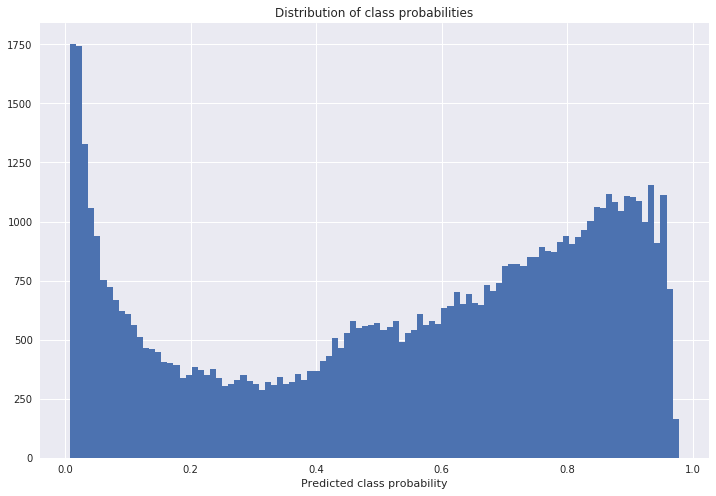

In [7]:
# Look at distribution.  There are some funny extreme modes we should try to understand.

fig, ax = plt.subplots()
ax.set_xlabel('Predicted class probability')
ax = df['prob'].hist(bins=100, figsize=(12, 8), ax=ax)
ax = ax.set_title('Distribution of class probabilities')

In [8]:
sn.color_palette()[1]

(0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

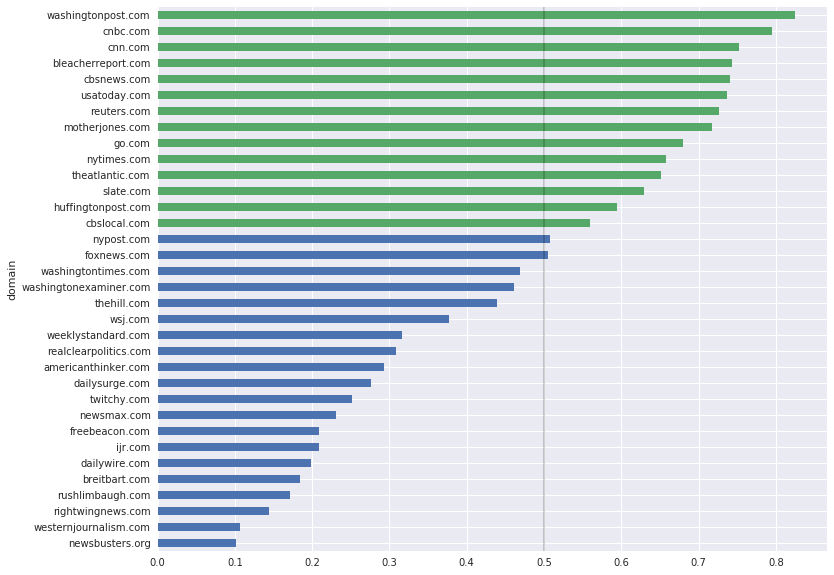

In [9]:
# Groupby domain name and take the average probability.  We can then round to 0/1 to 
# get a domain-level classification.

drop_less_than = 10  # Drop domains with fewer than this many observations

df_mean = df.groupby('domain')['encoded_label', 'prob'].mean()
df_count = df.groupby('domain')['domain'].count()
df_stats = pd.concat([df_mean, df_count], axis=1).sort_values('prob')
df_stats['num_correct'] = df_stats.apply(lambda x: int(np.round(x['prob'])) == x['encoded_label'], axis=1)
df_stats = df_stats[df_stats['domain'] >= drop_less_than]

colors = {0: sn.color_palette()[0], 1: sn.color_palette()[1]}

ax = df_stats['prob'].plot(kind='barh', figsize=(12, 10), color=[colors[i] for i in df_stats['encoded_label']])

ax = ax.axes.vlines(0.5, -19, 1000, alpha=.2)

In [10]:
# Count the number of correct domain-level classifications.
tf = df_stats.groupby('num_correct')['prob'].count()
print('Domain-level accuracy: {:1.1f}%'.format(100.*tf[True]/tf.sum()))

Domain-level accuracy: 94.1%


In [14]:
df[df['prob'] > 0.99].shape

(0, 8)

In [12]:
df[df['prob'] < 0.01]['domain'].value_counts()

westernjournalism.com    96
rightwingnews.com        76
newsbusters.org           8
breitbart.com             5
dailywire.com             5
ijr.com                   3
weeklystandard.com        1
Name: domain, dtype: int64

In [15]:
df[df['prob'] > 0.99]['domain'].value_counts()

Series([], Name: domain, dtype: int64)

In [16]:
hi = df[df['prob'] > 0.9]
hi[hi['domain'] == 'washingtonpost.com']['title'].head(10)

3      GOP health-care bill would drop addiction trea...
12     Opinion | The lawless obstructionism of Beltwa...
22     Scientists create ‘designer yeast’ in major st...
34     Perspective | The best cartoons making fun of ...
57     Perspective | Why the Trump administration hat...
81     Hogan launches efforts to fight poverty, impro...
102    Analysis | Trump’s ‘wingman’ just put up a big...
109    Perspective | In Redskins-Scot McCloughan saga...
110    30-year mortgage rate reaches new high for the...
234    Modernizing a 1929 Colonial while still honori...
Name: title, dtype: object

In [17]:
lo = df[df['prob'] < 0.01]
lo.shape

(194, 8)

In [18]:
lo[lo['domain'] == 'westernjournalism.com']['tokenized'].head(10)

644     watch_NOUN meghan_PROPN mccain_PROPN exposed_P...
761     rex_PROPN tillerson_PROPN make_VERB unpreceden...
1728    breaking_NOUN repub_PROPN blindsides_PROPN wit...
2300    breaking_NOUN gop_PROPN obamacare_PROPN repeal...
2311    watch_PROPN cnn_PROPN host_PROPN slap_VERB mar...
3434    breaking_NOUN arnold_PROPN schwarzenegger_PROP...
3843    watch_NOUN judge_PROPN jeanine_PROPN sees_PROP...
4690    watch_NOUN cnn_PROPN host_PROPN stop_VERB dead...
7392    watch_PROPN sheriff_PROPN clarke_PROPN got_PRO...
8183    top_PROPN cnn_PROPN host_PROPN breaks_PROPN si...
Name: tokenized, dtype: object

In [19]:
lo[lo['domain'] == 'westernjournalism.com']['tokenized'].ix[644]

u'watch_NOUN meghan_PROPN mccain_PROPN exposed_PROPN the_DET shocking_PROPN truth_PROPN about_ADP obama_PROPN with_ADP word_NOUN'

In [26]:
in_model, out_model = rnn.split_model_layers(model, topn, embed_dim, dense_dim, gru_dim, maxlen, bidirectional)

In [27]:
rnn.evaluate_sequential_probs(X, 22, in_model, out_model)

array([ 0.00138694,  0.00069358,  0.0005895 ,  0.00052657,  0.00048766,
        0.00044313,  0.00041836,  0.00041846,  0.00040906,  0.00039268,
        0.00039244,  0.00039615,  0.00040004,  0.00040352,  0.00040652,
        0.00040913,  0.0004114 ,  0.00041341,  0.00041521,  0.00041684], dtype=float32)

In [48]:
df.ix[177, 'text']

u' Rep. Cummings asks Trump to soften talk about black communities Video - ABC News Sections Sections Top Stories Watch U.S. International Politics Lifestyle Entertainment Health Tech Investigative Sports Weather Shows Shows Good Morning America World News Tonight Nightline 20/20 This Week What Would You Do? Live Live Demonstrators react to court ruling on the impeached South Korean President RADAR: Severe weather and heavy snow across the East Sydney Opera House in Sydney Harbor Skiers hit the slopes in Copper Mountain, Colo. Penguin cam from the Kansas City Zoo in Missouri Bald eagle tends to her eaglet in Fort Myers, Fla. Ocean Voyager webcam at the Georgia Aquarium Barrier reef cam from the Georgia Aquarium Old Faithful geyser in Yellowstone National Park More Privacy Policy Your CA Privacy Rights Children\'s Online Privacy Policy Interest-Based Ads Terms of Use Contact Us Yahoo!-ABC News Network | \xa9 2017 ABC News Internet Ventures. All rights reserved. Search Menu ABC News Log 

In [51]:
df.ix[177, 'url']

u'http://abcnews.go.com/Politics/video/rep-cummings-asks-trump-soften-talk-black-communities-46016256'